# 02 — Task 1: EDA, Stationarity & Risk Metrics

In [18]:
import os
# 👉 change this to YOUR real folder that contains the data/ from GMF_01
os.environ["GMF_DRIVE_PROJECT_DIR"] = "/content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization"


In [19]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_DIR = os.environ.get("GMF_DRIVE_PROJECT_DIR", "/content/drive/MyDrive/GMF_Project")
DATA_DIR = os.path.join(BASE_DIR, "data")
print("BASE_DIR:", BASE_DIR)
print("DATA_DIR:", DATA_DIR)
print("DATA_DIR exists? ", os.path.isdir(DATA_DIR))
print("Contents of data/:", os.listdir(DATA_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization
DATA_DIR: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data
DATA_DIR exists?  True
Contents of data/: ['TSLA_1d.csv', 'BND_1d.csv', 'SPY_1d.csv', 'prices_adj_close.csv', 'returns_daily.csv']


In [15]:
import os, pandas as pd, numpy as np

def load_adj_close(csv_path: str) -> pd.Series:
    # Read with date index; tolerate weird date formats
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    # Column name variants
    for col in ["Adj Close", "AdjClose", "Adj_Close", "Adjclose"]:
        if col in df.columns:
            s = df[col]
            break
    else:
        raise ValueError(f"'Adj Close' column not found in {csv_path}. Columns: {list(df.columns)}")

    # Clean and coerce to numeric (handles commas/strings)
    s = s.astype(str).str.replace(",", "", regex=False).str.strip()
    s = pd.to_numeric(s, errors="coerce")
    s.name = os.path.basename(csv_path).split("_")[0]  # TSLA/BND/SPY
    return s

paths = {
    "TSLA": os.path.join(DATA_DIR, "TSLA_1d.csv"),
    "BND":  os.path.join(DATA_DIR, "BND_1d.csv"),
    "SPY":  os.path.join(DATA_DIR, "SPY_1d.csv"),
}

# Load each series robustly
adj_series = []
for tk, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing {p}. Run GMF_01 first.")
    s = load_adj_close(p)
    adj_series.append(s)

# Combine to wide prices table, align on common dates
prices = pd.concat(adj_series, axis=1).sort_index()

# Optional: forward-fill isolated missing values inside the range
# (Keeps leading NaNs intact so we can drop them once.)
prices = prices.ffill()

# Drop any rows still missing any ticker (e.g., early holidays)
prices = prices.dropna(how="any")

# Sanity checks
print(prices.dtypes)
display(prices.head(), prices.tail())

# Save combined files
prices_path  = os.path.join(DATA_DIR, "prices_adj_close.csv")
returns_path = os.path.join(DATA_DIR, "returns_daily.csv")
prices.to_csv(prices_path)

# Use fill_method=None to avoid the FutureWarning; then drop the first NaN row
returns = prices.pct_change(fill_method=None)
returns = returns.dropna(how="any")
returns.to_csv(returns_path)

print("Created:", prices_path, "and", returns_path)


/tmp/ipython-input-1889123162.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
/tmp/ipython-input-1889123162.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
/tmp/ipython-input-1889123162.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, index_col=0, parse_dates=True)


TSLA    float64
BND     float64
SPY     float64
dtype: object


,TSLA,BND,SPY
Price,,,
2015-07-01,17.943333,60.816746,174.917099
2015-07-02,18.667999,60.967060,174.756973
2015-07-06,18.648001,61.177570,174.259567
2015-07-07,17.858667,61.237709,175.355438
2015-07-08,16.997334,61.410625,172.413483


,TSLA,BND,SPY
Price,,,
2025-07-28,325.589996,72.758659,636.940002
2025-07-29,321.200012,73.137398,635.260010
2025-07-30,319.040009,72.948036,634.460022
Date,319.040009,72.948036,634.460022
Ticker,319.040009,72.948036,634.460022


Created: /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data/prices_adj_close.csv and /content/drive/MyDrive/KAIM/week 11/gmf-time-series-portfolio-optimization/data/returns_daily.csv


In [20]:
# === Ensure combined CSVs exist (build from per-ticker files if needed) ===
import pandas as pd, os

prices_path  = os.path.join(DATA_DIR, "prices_adj_close.csv")
returns_path = os.path.join(DATA_DIR, "returns_daily.csv")

if not (os.path.exists(prices_path) and os.path.exists(returns_path)):
    print("Combined CSVs not found. Attempting to build from per-ticker CSVs...")
    paths = {
        "TSLA": os.path.join(DATA_DIR, "TSLA_1d.csv"),
        "BND":  os.path.join(DATA_DIR, "BND_1d.csv"),
        "SPY":  os.path.join(DATA_DIR, "SPY_1d.csv"),
    }
    missing = [tk for tk,p in paths.items() if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(f"Missing per-ticker files: {missing}. Run GMF_01 to fetch data first.")
    # Load 'Adj Close' columns
    adj = {}
    for tk, p in paths.items():
        df = pd.read_csv(p, index_col=0, parse_dates=True)
        if "Adj Close" not in df.columns:
            raise ValueError(f"{tk}: 'Adj Close' column not found in {p}")
        adj[tk] = df["Adj Close"]
    prices = pd.DataFrame(adj).sort_index()
    prices.to_csv(prices_path)
    returns = prices.pct_change().dropna()
    returns.to_csv(returns_path)
    print("Created:", prices_path, "and", returns_path)
else:
    print("Found existing combined CSVs.")

Found existing combined CSVs.


In [21]:
# === Load datasets ===
import pandas as pd
prices  = pd.read_csv(os.path.join(DATA_DIR, "prices_adj_close.csv"), index_col=0, parse_dates=True)
returns = pd.read_csv(os.path.join(DATA_DIR, "returns_daily.csv"), index_col=0, parse_dates=True)
display(prices.tail(), returns.tail())

,TSLA,BND,SPY
Price,,,
2025-07-28,325.589996,72.758659,636.940002
2025-07-29,321.200012,73.137398,635.260010
2025-07-30,319.040009,72.948036,634.460022
Date,319.040009,72.948036,634.460022
Ticker,319.040009,72.948036,634.460022


,TSLA,BND,SPY
Price,,,
2025-07-28,0.030152,-0.001641,-0.000251
2025-07-29,-0.013483,0.005205,-0.002638
2025-07-30,-0.006725,-0.002589,-0.001259
Date,0.000000,0.000000,0.000000
Ticker,0.000000,0.000000,0.000000


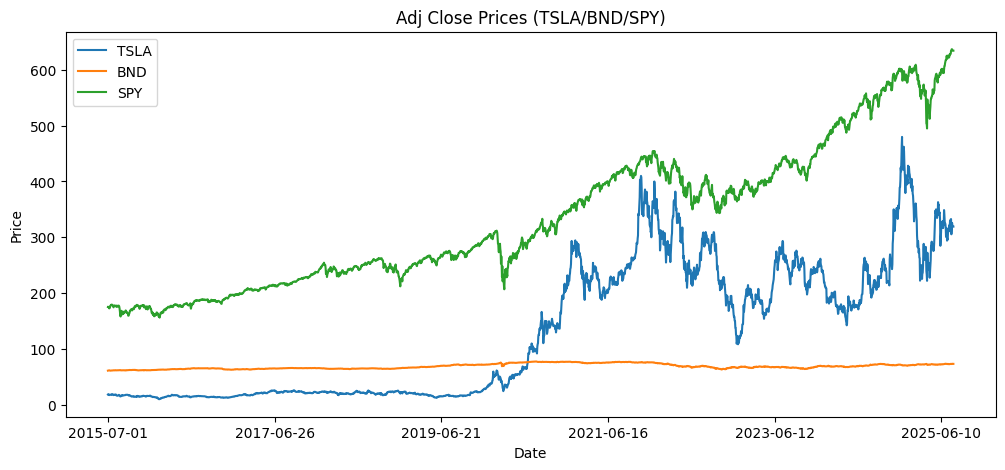

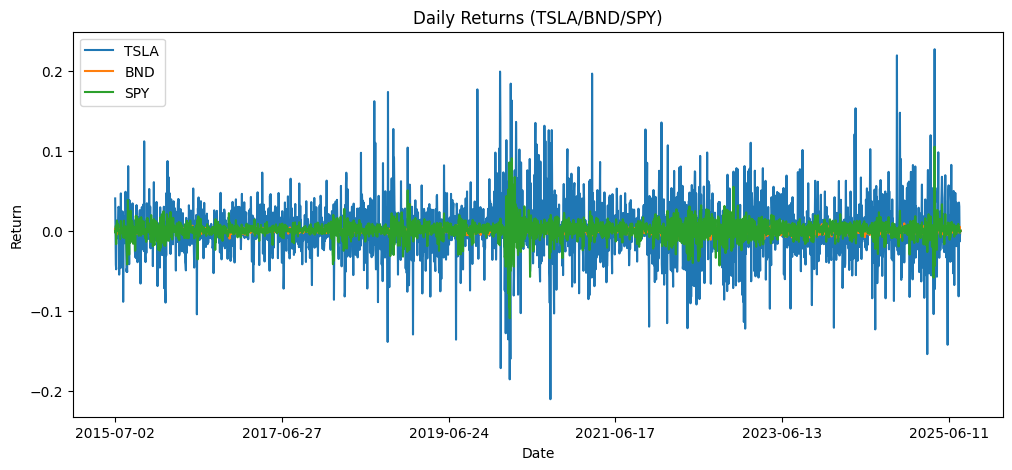

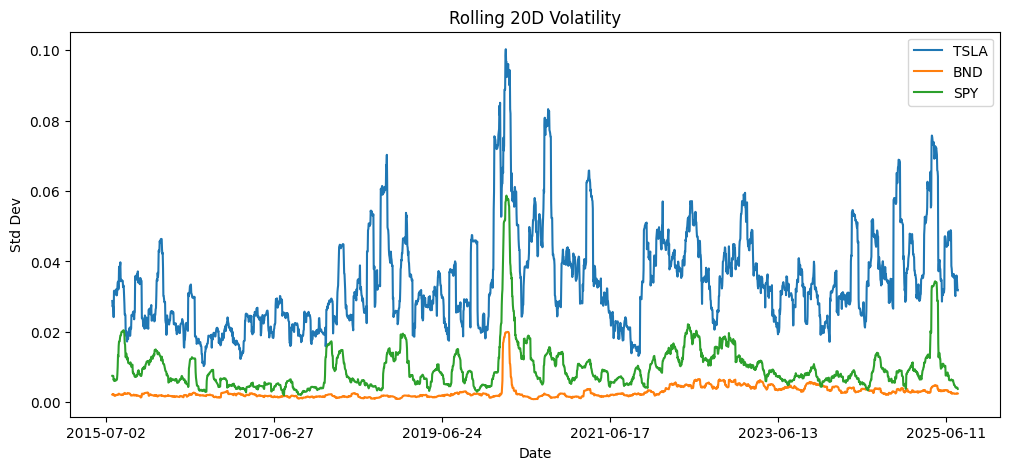

In [22]:
# === EDA Plots ===
import matplotlib.pyplot as plt

# Prices
ax = prices.plot(figsize=(12,5), title="Adj Close Prices (TSLA/BND/SPY)")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.figure.savefig(os.path.join(OUT_PLOTS, "prices.png")); plt.show()

# Daily returns
ax = returns.plot(figsize=(12,5), title="Daily Returns (TSLA/BND/SPY)")
ax.set_xlabel("Date"); ax.set_ylabel("Return")
ax.figure.savefig(os.path.join(OUT_PLOTS, "returns.png")); plt.show()

# Rolling 20-day volatility
rolling_vol = returns.rolling(20).std()
ax = rolling_vol.plot(figsize=(12,5), title="Rolling 20D Volatility")
ax.set_xlabel("Date"); ax.set_ylabel("Std Dev")
ax.figure.savefig(os.path.join(OUT_PLOTS, "rolling_vol.png")); plt.show()

In [23]:
# === Outlier Detection (|z| > 3) ===
import numpy as np
z = (returns - returns.mean())/returns.std()
outliers = {c: returns[c][z[c].abs() > 3] for c in returns.columns}
print("Top 10 outliers per ticker by absolute return:")
for c, s in outliers.items():
    print(f"\n{c}:")
    display(s.sort_values(key=lambda x: x.abs(), ascending=False).head(10))

Top 10 outliers per ticker by absolute return:

TSLA:


,TSLA
Price,
2025-04-09,0.226900
2024-10-24,0.219190
2020-09-08,-0.210628
2020-02-03,0.198949
2021-03-09,0.196412
2020-03-16,-0.185778
2020-03-19,0.183877
2019-10-24,0.176692
2018-10-01,0.173471



BND:


,BND
Price,
2020-03-12,-0.054385
2020-03-13,0.042201
2020-03-18,-0.024140
2020-03-23,0.022149
2022-11-10,0.020703
2020-03-17,-0.020686
2020-03-11,-0.018940
2020-03-20,0.016955
2022-06-13,-0.016153



SPY:


,SPY
Price,
2020-03-16,-0.109424
2025-04-09,0.105019
2020-03-12,-0.095677
2020-03-24,0.090603
2020-03-13,0.085486
2020-03-09,-0.078094
2020-04-06,0.067166
2025-04-04,-0.058543
2020-03-26,0.058390


In [24]:
# === Stationarity: ADF Tests ===
from statsmodels.tsa.stattools import adfuller

def adf_stats(series):
    s = series.dropna().astype(float)
    stat,p,usedlag,nobs,crit,icbest = adfuller(s, autolag='AIC')
    return {"stat":stat, "pvalue":p, "crit":crit, "nobs":nobs}

print("ADF — TSLA price:", adf_stats(prices["TSLA"]))
print("ADF — TSLA returns:", adf_stats(returns["TSLA"]))

ADF — TSLA price: {'stat': np.float64(-1.4098205760214313), 'pvalue': np.float64(0.5775590605264328), 'crit': {'1%': np.float64(-3.432959008741782), '5%': np.float64(-2.862692648021296), '10%': np.float64(-2.567383598871881)}, 'nobs': 2509}
ADF — TSLA returns: {'stat': np.float64(-34.695939632903205), 'pvalue': 0.0, 'crit': {'1%': np.float64(-3.43293324257297), '5%': np.float64(-2.8626812695784225), '10%': np.float64(-2.5673775408540145)}, 'nobs': 2534}


In [25]:
# === Risk Metrics: VaR(95%) & Annualized Sharpe ===
TRADING_DAYS = 252
RISK_FREE_DAILY = 0.0

def var_hist(r, alpha=0.95):
    return abs(float(r.quantile(1 - alpha)))

def sharpe_ann(r, rf=0.0, td=252):
    ex = r - rf
    mu = ex.mean() * td
    sig = ex.std(ddof=0) * (td ** 0.5)
    return (mu / sig) if sig > 0 else float("nan")

metrics = {}
for tk in ["TSLA","BND","SPY"]:
    metrics[tk] = {"VaR95": var_hist(returns[tk]), "Sharpe_ann": sharpe_ann(returns[tk], RISK_FREE_DAILY)}

import json
metrics_path = os.path.join(OUT_METRICS, "task1_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved metrics to:", metrics_path)
metrics

Saved metrics to: outputs/metrics/task1_metrics.json


{'TSLA': {'VaR95': 0.054650328403958934,
  'Sharpe_ann': np.float64(0.7781862633639587)},
 'BND': {'VaR95': 0.004896366624743271,
  'Sharpe_ann': np.float64(0.3568075793343567)},
 'SPY': {'VaR95': 0.017168916309954818,
  'Sharpe_ann': np.float64(0.7939152472407304)}}